
# DS6050 - Group 6
* Andrej Erkelens <wsw3fa@virginia.edu>
* Robert Knuuti <uqq5zz@virginia.edu>
* Khoi Tran <kt2np@virginia.edu>

## Abstract
English is a verbose language with over 69% redundancy in its construction, and as a result, individuals only need to identify important details to comprehend an intended message.
While there are strong efforts to quantify the various elements of language, the average individual can still comprehend a written message that has errors, either in spelling or in grammar.
The emulation of the effortless, yet obscure task of reading, writing, and understanding language is the perfect challenge for the biologically-inspired methods of deep learning.
Most language and text related problems rely upon finding high-quality latent representations to understand the task at hand. Unfortunately, efforts to overcome such problems are limited to the data and computation power available to individuals; data availability often presents the largest problem, with small, specific domain tasks often proving to be limiting.
Currently, these tasks are often aided or overcome by pre-trained large language models (LLMs), designed by large corporations and laboratories.
Fine-tuning language models on domain-specific vocabulary with small data sizes still presents a challenge to the language community, but the growing availability of LLMs to augment such models alleviates the challenge.
This paper explores different techniques to be applied on existing language models (LMs), built highly complex Deep Learning models, and investigates how to fine-tune these models, such that a pre-trained model is used to enrich a more domain-specific model that may be limited in textual data.

## Project Objective

We are aiming on using several small domain specific language tasks, particularly classification tasks.
We aim to take at least two models, probably BERT and distill-GPT2 as they seem readily available on HuggingFace and TensorFlow's model hub.
We will iterate through different variants of layers we fine tune and compare these results with fully trained models, and ideally find benchmarks already in academic papers on all of the datasets.

We aim to optimize compute efficiency and also effectiveness of the model on the given dataset. Our goal is to find a high performing and generalizable method for our fine tuning process and share this in our paper.


In [1]:
%autosave 0

Autosave disabled


In [2]:
!pip install -q tensorflow-addons tensorflow-text tokenizers transformers

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_text as tf_text

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/ds6050/git/

/content/drive/MyDrive/ds6050/git


In [64]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tokenizers
import torch
import transformers

from sklearn import metrics
from tensorflow import keras
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_feather("data-extractor/data/dataset.feather")#.set_index('index')
df['topic'] = df['topic'].str.split('.').str[0]
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)

features = 'content' # feature for the future - add all the datasets ['categories', 'summary', 'content']
label = 'topic'

In [6]:
# strategy = tf.distribute.MirroredStrategy()

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# 7 different topics
# y_ = ohe.fit_transform(df['topic'].values.reshape(-1,1)).toarray()
y_train = ohe.fit_transform(df_train['topic'].values.reshape(-1,1)).toarray()
y_test  = ohe.fit_transform(df_test['topic'].values.reshape(-1,1)).toarray()

#max_len = 512
checkpoint = 'gpt2'
hf_gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained(checkpoint, add_prefix_space=True)
hf_gpt2_model = transformers.TFGPT2Model.from_pretrained(checkpoint)
# hf_gpt2_model = transformers.GPT2ForSequenceClassification.from_pretrained(checkpoint)

# add for gpt2 padding
if hf_gpt2_tokenizer.pad_token is None:
    hf_gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
hf_gpt2_model.resize_token_embeddings(len(hf_gpt2_tokenizer))

## create model
def model_top(pretr_model):
  input_ids = tf.keras.Input(shape=(32,), dtype='int32')
  attention_mask = tf.keras.Input(shape=(32,), dtype='int32')

  output = pretr_model(input_ids = input_ids, attention_mask = attention_mask)
  # output = pretr_model([input_ids, attention_mask])
  #pooler_output = output[1]
  pooler_output = tf.keras.layers.AveragePooling1D(pool_size=32)(output[0])
  flattened_output = tf.keras.layers.Flatten()(pooler_output)
  
  output = tf.keras.layers.Dense(32, activation='tanh')(flattened_output)
  #output = tf.keras.layers.Dropout(0.2)(output)
  output = tf.keras.layers.Dropout(0.4)(output)

  output = tf.keras.layers.Dense(7, activation='softmax')(output)
  model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# save_path = Path('models')
# if not os.path.exists(save_path):
#     os.makedirs(save_path, exist_ok=True)
# hf_gpt2_tokenizer.save_pretrained(save_path)
# model.save_pretrained(save_path)
# model.save_weights(save_path)


## batch encoding
# encodings = hf_gpt2_tokenizer.batch_encode_plus(list(df.summary.values), 
#                                                 return_tensors='tf', 
#                                                 padding='max_length',
#                                                 #add_special_tokens=True,
#                                                 max_length=32,
#                                                 truncation=True)

train_encodings = hf_gpt2_tokenizer.batch_encode_plus(list(df_train.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length=32,
                                                      truncation=True)

test_encodings  = hf_gpt2_tokenizer.batch_encode_plus(list(df_test.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length=32,
                                                      truncation=True)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.
Using pad_token, but it is not set yet.


In [7]:
model = model_top(hf_gpt2_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 32, 768                                           

In [8]:
model.layers

In [9]:
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 32, 768                                           

In [10]:
!nvidia-smi

Mon Aug  8 06:44:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   2580MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
checkpoint_filepath = './tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    mode="auto",
)

history = model.fit([train_encodings['input_ids'], 
                     train_encodings['attention_mask']], 
                    y_train, 
                    validation_split=.2,
                    epochs=8,
                    batch_size=32,
                    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/8
901/901 [==============================] - 258s 270ms/step - loss: 1.6129 - accuracy: 0.4157 - val_loss: 1.0822 - val_accuracy: 0.6372
Epoch 2/8
901/901 [==============================] - 235s 261ms/step - loss: 0.9857 - accuracy: 0.6696 - val_loss: 1.0736 - val_accuracy: 0.6328
Epoch 3/8
901/901 [==============================] - 239s 265ms/step - loss: 0.7453 - accuracy: 0.7552 - val_loss: 1.1650 - val_accuracy: 0.6080


In [45]:
predict_train_data = model.predict([train_encodings['input_ids'], train_encodings['attention_mask']], batch_size=4)
pred_train_data = np.argmax(predict_train_data, axis = 1)
train_cm = metrics.confusion_matrix(np.argmax(y_train, axis = 1), pred_train_data)

predict_test_data = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
pred_test_data = np.argmax(predict_test_data, axis = 1)
test_cm = metrics.confusion_matrix(np.argmax(y_test, axis = 1), pred_test_data)

282/282 [==============================] - 20s 72ms/step


In [22]:
predict_test_data = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
pred_test_data = np.argmax(predict_test_data, axis = 1)

282/282 [==============================] - 20s 71ms/step


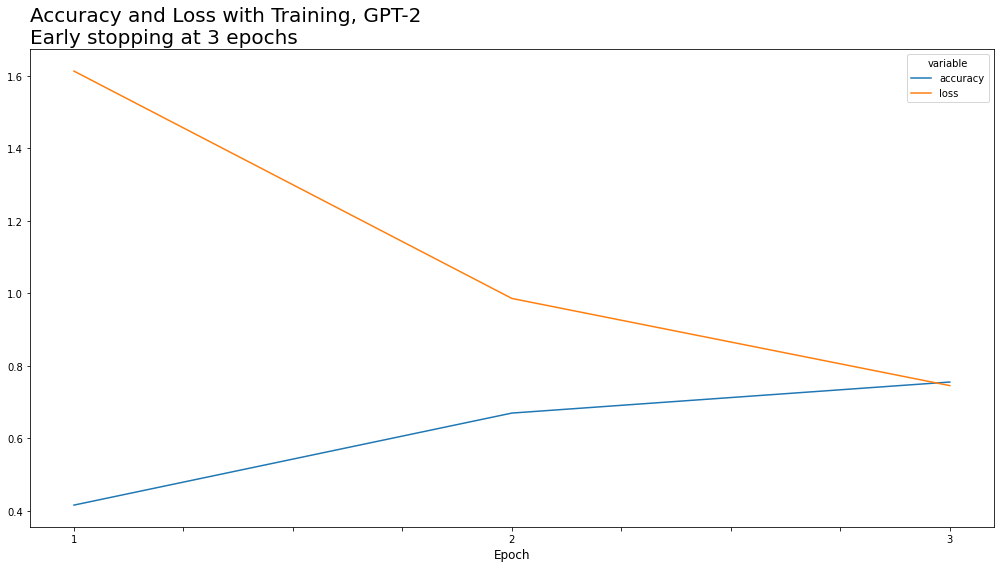

In [185]:
history_df = pd.DataFrame(np.array([history.history['accuracy'], history.history['loss']]).T, columns = ['accuracy', 'loss'])
history_df = history_df.reset_index().rename(columns = {'index': 'epoch'})
history_df['epoch'] = history_df['epoch'] + 1
history_df = pd.melt(history_df, id_vars = 'epoch', value_vars = ['accuracy', 'loss'])

fig, ax = plt.subplots(1, 1, figsize = (14,8))
sns.lineplot(x = 'epoch', y = 'value', hue = 'variable', data = history_df);
# labels, title and ticks
ax.set_xlabel('Epoch', fontsize = 12);
ax.set_ylabel(''); 
ax.set_title('Accuracy and Loss with Training, GPT-2', loc = 'left', fontsize = 20); 
ax.xaxis.set_ticklabels(['','1','','','','2','','','','3']); 
plt.tight_layout()
plt.show()

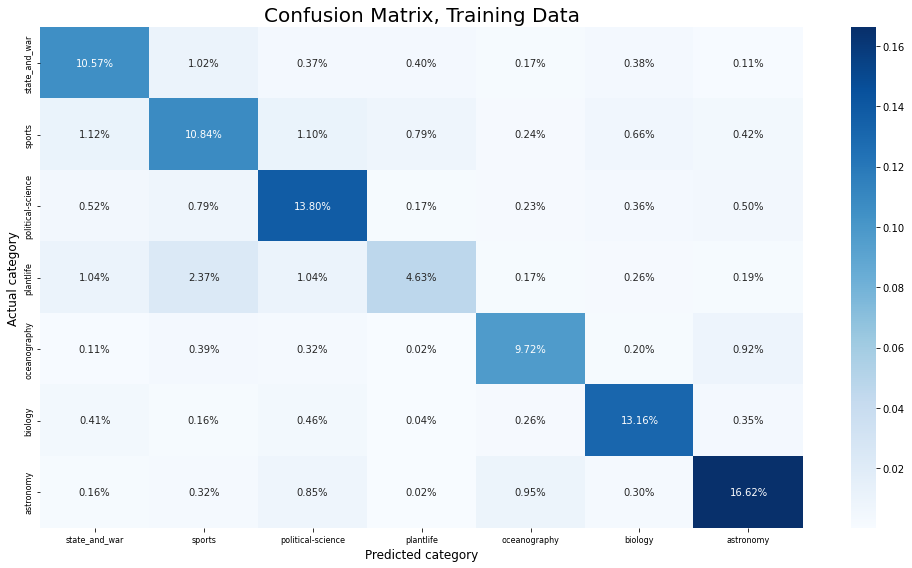

In [176]:
labels = list(df['topic'].unique())
labels.sort()
x_labs = labels
labels.sort(reverse = True)
y_labs = labels

fig, ax = plt.subplots(1, 1, figsize = (14,8))
sns.heatmap(train_cm/np.sum(train_cm), annot=True, fmt='.2%', cmap='Blues');
# labels, title and ticks
ax.set_xlabel('Predicted category', fontsize = 12);
ax.set_ylabel('Actual category', fontsize = 12); 
ax.set_title('Confusion Matrix, Training Data', fontsize = 20); 
ax.xaxis.set_ticklabels(x_labs, fontsize = 8); 
ax.yaxis.set_ticklabels(y_labs, fontsize = 8);
plt.tight_layout()
plt.show()

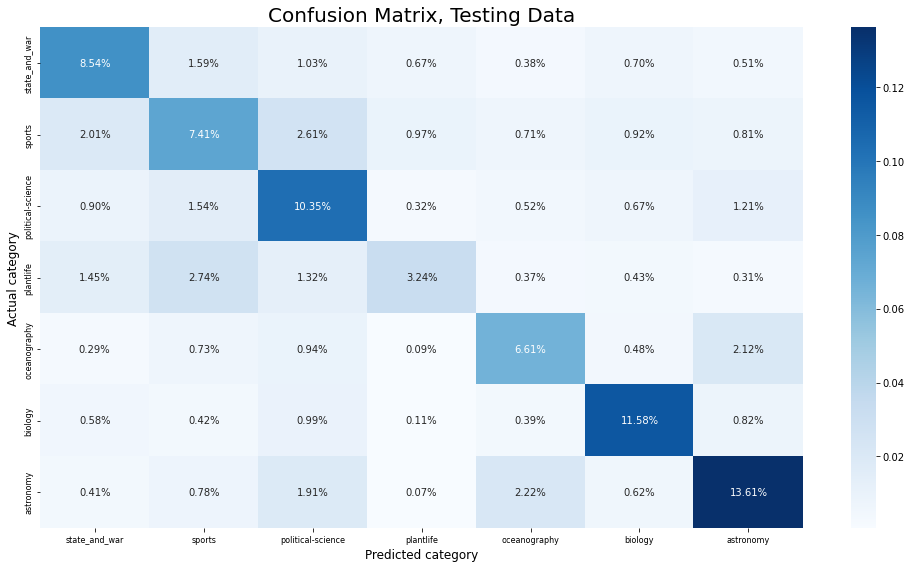

In [175]:
fig, ax = plt.subplots(1, 1, figsize = (14,8))
sns.heatmap(test_cm/np.sum(test_cm), annot=True, fmt='.2%', cmap='Blues');
# labels, title and ticks
ax.set_xlabel('Predicted category', fontsize = 12);
ax.set_ylabel('Actual category', fontsize = 12); 
ax.set_title('Confusion Matrix, Testing Data', fontsize = 20); 
ax.xaxis.set_ticklabels(x_labs, fontsize = 8); 
ax.yaxis.set_ticklabels(y_labs, fontsize = 8);
plt.tight_layout()
plt.show()

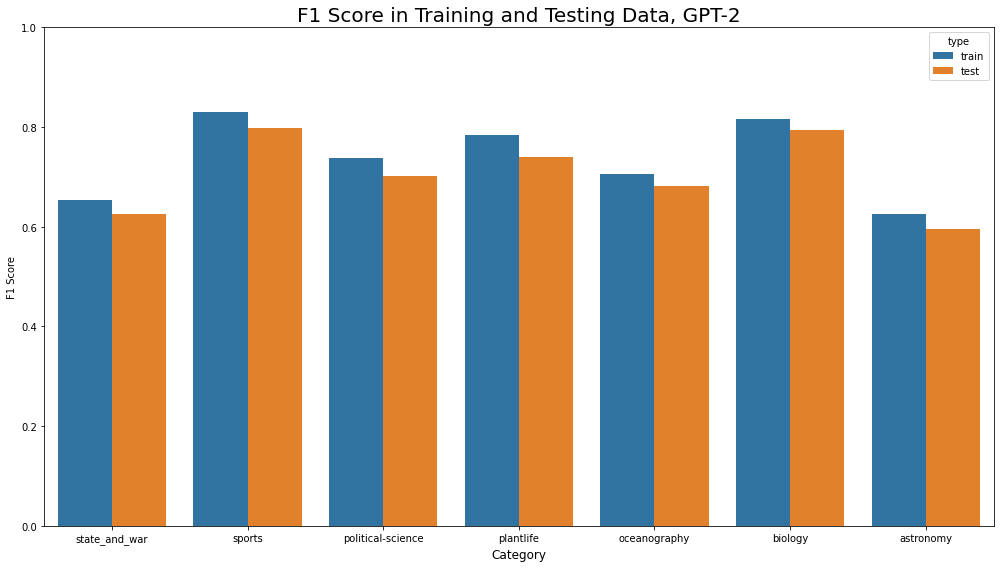

In [181]:
# see f1 scores
# threshold is just median/mean rounded up to the nearest 0.15
f1_metric = tfa.metrics.F1Score(num_classes = 7, threshold = 0.15)
f1_metric.update_state(y_train, predict_train_data)
train_f1 = f1_metric.result()
f1_metric.update_state(y_test, predict_test_data)
test_f1 = f1_metric.result()

# turn to dataframe
train_f1 = pd.Series(train_f1.numpy()).reset_index().rename(columns = {'index': 'category', 0: 'f1'})
train_f1['type'] = 'train'
test_f1  = pd.Series(test_f1.numpy()).reset_index().rename(columns  = {'index': 'category', 0: 'f1'})
test_f1['type']  = 'test'

gpt2_f1 = pd.concat([train_f1, test_f1]).reset_index(drop = True)\
            .replace({'category': {t: idx for idx, t in zip(sorted(df['topic'].unique()), range(7))}})\
            .sort_values(by = ['category', 'type'], ascending = False)

# plotting
plt.figure(figsize = (14,8))
# can't get it to sort alphabetically for some reason
ax = sns.barplot(x = 'category', y = 'f1', hue = 'type', data = gpt2_f1, order = list(set(gpt2_f1.category)));
# labels, title and ticks
ax.set_xlabel('Category', fontsize = 12);
ax.set_ylabel('F1 Score'); 
ax.set_title('F1 Score in Training and Testing Data, GPT-2', fontsize = 20); 
ax.xaxis.set_ticklabels(labels); 
ax.set_ylim([0, 1]);
plt.tight_layout()
plt.show()

In [14]:
"""from transformers.keras_callbacks import KerasMetricCallback


def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset
)"""

'from transformers.keras_callbacks import KerasMetricCallback\n\n\ndef compute_metrics(eval_predictions):\n    predictions, labels = eval_predictions\n    if task != "stsb":\n        predictions = np.argmax(predictions, axis=1)\n    else:\n        predictions = predictions[:, 0]\n    return metric.compute(predictions=predictions, references=labels)\n\n\nmetric_callback = KerasMetricCallback(\n    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset\n)'

In [15]:
"""with training_args.strategy.scope():
  model = hf_gpt2_model

trainer = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)"""

'with training_args.strategy.scope():\n  model = hf_gpt2_model\n\ntrainer = TFTrainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset\n)'

### Data Preview

In [16]:
"""for text, label in ds_train.take(5):
  print('Text')
  print(text)
  print('Label')
  print(label)"""

"for text, label in ds_train.take(5):\n  print('Text')\n  print(text)\n  print('Label')\n  print(label)"

In [17]:
"""## This is currently broken
max_len = 384
hf_gpt2_tokenizer_bootstrapper = transformers.BertTokenizer.from_pretrained("gpt2")
hf_gpt2_model = transformers.TFGPT2Model.from_pretrained("gpt2")

save_path = Path("data") / "models"
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)
hf_gpt2_tokenizer_bootstrapper.save_pretrained(save_path)
hf_gpt2_model.save_pretrained(save_path)

# Load the fast tokenizer from saved file
gpt2_tokenizer = tokenizers.GPT2TokenizerFast(str(save_path/"vocab.txt"), lowercase=True)

def tf_hf_gpt2encode(features, label):
    x = gpt2_tokenizer.encode(tf.compat.as_str(features), add_special_tokens=True)
    y = gpt2_tokenizer.encode(tf.compat.as_str(label), add_special_tokens=True)
    return x, y

def tf_hf_gpt2encodeds(features, label):
    encode = tf.py_function(func=tf_hf_gpt2encode, inp=[features, label], Tout=[tf.int64, tf.int64])
    return encode

encoded_input = ds_train.batch(256).map(tf_hf_gpt2encodeds)
output = transformers.TFGPT2Model(config=transformers.PretrainedConfig.from_json_file(str(save_path/"config.json")))
hf_gpt2 = output(encoded_input)"""

'## This is currently broken\nmax_len = 384\nhf_gpt2_tokenizer_bootstrapper = transformers.BertTokenizer.from_pretrained("gpt2")\nhf_gpt2_model = transformers.TFGPT2Model.from_pretrained("gpt2")\n\nsave_path = Path("data") / "models"\nif not os.path.exists(save_path):\n    os.makedirs(save_path, exist_ok=True)\nhf_gpt2_tokenizer_bootstrapper.save_pretrained(save_path)\nhf_gpt2_model.save_pretrained(save_path)\n\n# Load the fast tokenizer from saved file\ngpt2_tokenizer = tokenizers.GPT2TokenizerFast(str(save_path/"vocab.txt"), lowercase=True)\n\ndef tf_hf_gpt2encode(features, label):\n    x = gpt2_tokenizer.encode(tf.compat.as_str(features), add_special_tokens=True)\n    y = gpt2_tokenizer.encode(tf.compat.as_str(label), add_special_tokens=True)\n    return x, y\n\ndef tf_hf_gpt2encodeds(features, label):\n    encode = tf.py_function(func=tf_hf_gpt2encode, inp=[features, label], Tout=[tf.int64, tf.int64])\n    return encode\n\nencoded_input = ds_train.batch(256).map(tf_hf_gpt2encodeds)

In [18]:
"""
files = [] # Need to explode train_ds to sep files

tokenizer = tokenizers.GPT2TokenizerFast(
    clean_text=True,
    handle_chinese_chars=True,
    strip_accents=True,
    lowercase=True,
)

tokenizer.train(
    files,
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
    limit_alphabet=1000,
    wordpieces_prefix="##",
)

# Save the files
tokenizer.save_model(args.out, args.name)"""

'\nfiles = [] # Need to explode train_ds to sep files\n\ntokenizer = tokenizers.GPT2TokenizerFast(\n    clean_text=True,\n    handle_chinese_chars=True,\n    strip_accents=True,\n    lowercase=True,\n)\n\ntokenizer.train(\n    files,\n    vocab_size=10000,\n    min_frequency=2,\n    show_progress=True,\n    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],\n    limit_alphabet=1000,\n    wordpieces_prefix="##",\n)\n\n# Save the files\ntokenizer.save_model(args.out, args.name)'